# Chapter 5: The Mandelbrot Set
*Based on B. Branner*

## Summary

The Mandelbrot set $M$ is the parameter space for quadratic polynomials — it catalogs all possible Julia sets. Key concepts:

- **Definition**: $M = \{c \in \mathbb{C} : f_c^n(0) \not\to \infty\}$ — values of $c$ for which the critical orbit stays bounded
- **Connection to Julia sets**: $c \in M$ iff $J_c$ is connected
- **Cardioid and bulbs**: The main cardioid contains $c$ values with attracting fixed points
- **Self-similarity**: Miniature copies of $M$ appear at all scales
- **Boundary complexity**: The boundary of $M$ has Hausdorff dimension 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from ipywidgets import interact, FloatSlider, IntSlider
%matplotlib inline
plt.style.use('dark_background')

## 5.1 The Mandelbrot Set

In [2]:
@jit(nopython=True, parallel=True)
def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iter):
    """Compute Mandelbrot set escape times"""
    result = np.zeros((height, width))
    
    for i in prange(height):
        for j in range(width):
            c_real = xmin + (xmax - xmin) * j / width
            c_imag = ymin + (ymax - ymin) * i / height
            
            zx, zy = 0.0, 0.0
            n = 0
            
            while zx*zx + zy*zy < 4 and n < max_iter:
                zx, zy = zx*zx - zy*zy + c_real, 2*zx*zy + c_imag
                n += 1
            
            result[height - 1 - i, j] = n
    
    return result

def plot_mandelbrot(center_x=-0.5, center_y=0.0, zoom=1.0, max_iter=200):
    """Plot Mandelbrot set with interactive zoom"""
    half_width = 1.5 / zoom
    half_height = 1.5 / zoom
    
    xmin, xmax = center_x - half_width, center_x + half_width
    ymin, ymax = center_y - half_height, center_y + half_height
    
    result = mandelbrot_set(xmin, xmax, ymin, ymax, 800, 800, max_iter)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(result, extent=[xmin, xmax, ymin, ymax], cmap='hot')
    ax.set_xlabel('Re(c)')
    ax.set_ylabel('Im(c)')
    ax.set_title('The Mandelbrot Set')
    plt.colorbar(im, label='Escape time')
    plt.show()

interact(plot_mandelbrot,
         center_x=FloatSlider(min=-2.5, max=1.0, step=0.01, value=-0.5, description='Center X'),
         center_y=FloatSlider(min=-1.5, max=1.5, step=0.01, value=0.0, description='Center Y'),
         zoom=FloatSlider(min=1, max=1000, step=1, value=1, description='Zoom'),
         max_iter=IntSlider(min=50, max=1000, step=50, value=200, description='Iterations'));

interactive(children=(FloatSlider(value=-0.5, description='Center X', max=1.0, min=-2.5, step=0.01), FloatSlid…

## 5.2 Interesting Locations

Explore famous regions of the Mandelbrot set.

In [3]:
locations = {
    'Full Set': (-0.5, 0.0, 1),
    'Seahorse Valley': (-0.75, 0.1, 20),
    'Elephant Valley': (0.275, 0.0, 20),
    'Triple Spiral': (-0.088, 0.654, 100),
    'Mini Mandelbrot': (-1.769, 0.0, 50),
    'Antenna': (-1.4, 0.0, 5),
    'Lightning': (-1.315, 0.073, 200),
}

def explore_location(name):
    cx, cy, zoom = locations[name]
    half_width = 1.5 / zoom
    
    result = mandelbrot_set(cx - half_width, cx + half_width, 
                            cy - half_width, cy + half_width, 
                            800, 800, 500)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(result, extent=[cx - half_width, cx + half_width,
                              cy - half_width, cy + half_width], 
              cmap='twilight_shifted')
    ax.set_xlabel('Re(c)')
    ax.set_ylabel('Im(c)')
    ax.set_title(f'{name} (zoom: {zoom}x)')
    plt.show()

from ipywidgets import Dropdown
interact(explore_location, 
         name=Dropdown(options=list(locations.keys()), value='Seahorse Valley'));

interactive(children=(Dropdown(description='name', index=1, options=('Full Set', 'Seahorse Valley', 'Elephant …

## 5.3 Period Detection

Color the Mandelbrot set by the period of the attracting cycle.

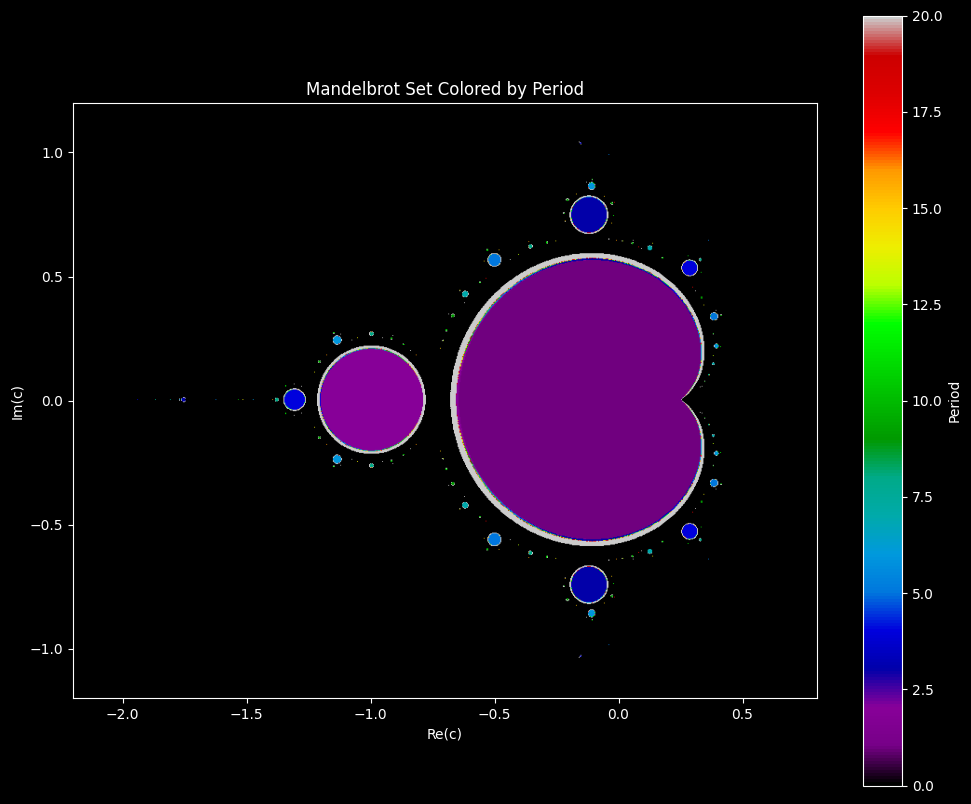

In [4]:
@jit(nopython=True, parallel=True)
def mandelbrot_periods(xmin, xmax, ymin, ymax, width, height, max_iter):
    """Detect period of attracting cycles"""
    result = np.zeros((height, width))
    
    for i in prange(height):
        for j in range(width):
            c_real = xmin + (xmax - xmin) * j / width
            c_imag = ymin + (ymax - ymin) * i / height
            
            zx, zy = 0.0, 0.0
            
            # Iterate to approach attractor
            for _ in range(max_iter):
                zx, zy = zx*zx - zy*zy + c_real, 2*zx*zy + c_imag
                if zx*zx + zy*zy > 4:
                    result[height - 1 - i, j] = 0  # Escaped
                    break
            else:
                # Detect period using Floyd's algorithm
                # Tortoise
                tx, ty = zx, zy
                # Hare
                hx, hy = zx*zx - zy*zy + c_real, 2*zx*zy + c_imag
                
                for period in range(1, 100):
                    if abs(tx - hx) < 1e-10 and abs(ty - hy) < 1e-10:
                        result[height - 1 - i, j] = period
                        break
                    # Move tortoise one step
                    tx, ty = tx*tx - ty*ty + c_real, 2*tx*ty + c_imag
                    # Move hare two steps
                    hx, hy = hx*hx - hy*hy + c_real, 2*hx*hy + c_imag
                    hx, hy = hx*hx - hy*hy + c_real, 2*hx*hy + c_imag
    
    return result

def plot_periods():
    result = mandelbrot_periods(-2.2, 0.8, -1.2, 1.2, 800, 800, 200)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(result, extent=[-2.2, 0.8, -1.2, 1.2], 
                   cmap='nipy_spectral', vmin=0, vmax=20)
    ax.set_xlabel('Re(c)')
    ax.set_ylabel('Im(c)')
    ax.set_title('Mandelbrot Set Colored by Period')
    plt.colorbar(im, label='Period')
    plt.show()

plot_periods()

## 5.4 Distance Estimation

Use the distance estimator to render sharp boundaries.

In [5]:
@jit(nopython=True, parallel=True)
def mandelbrot_distance(xmin, xmax, ymin, ymax, width, height, max_iter):
    """Compute distance estimate to boundary"""
    result = np.zeros((height, width))
    
    for i in prange(height):
        for j in range(width):
            c_real = xmin + (xmax - xmin) * j / width
            c_imag = ymin + (ymax - ymin) * i / height
            
            zx, zy = 0.0, 0.0
            # Derivative dz/dc
            dx, dy = 0.0, 0.0
            
            for n in range(max_iter):
                # d(z²+c)/dc = 2z·dz/dc + 1
                new_dx = 2 * (zx*dx - zy*dy) + 1
                new_dy = 2 * (zx*dy + zy*dx)
                dx, dy = new_dx, new_dy
                
                zx, zy = zx*zx - zy*zy + c_real, 2*zx*zy + c_imag
                
                z_mag = np.sqrt(zx*zx + zy*zy)
                if z_mag > 1000:
                    d_mag = np.sqrt(dx*dx + dy*dy)
                    dist = z_mag * np.log(z_mag) / d_mag
                    result[height - 1 - i, j] = dist
                    break
    
    return result

def plot_distance_estimate(center_x=-0.5, center_y=0.0, zoom=1.0):
    half_width = 1.5 / zoom
    
    dist = mandelbrot_distance(center_x - half_width, center_x + half_width,
                                center_y - half_width, center_y + half_width,
                                800, 800, 500)
    
    # Apply log scaling for visualization
    dist = np.log(dist + 1e-10)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(dist, extent=[center_x - half_width, center_x + half_width,
                            center_y - half_width, center_y + half_width],
              cmap='inferno')
    ax.set_xlabel('Re(c)')
    ax.set_ylabel('Im(c)')
    ax.set_title('Mandelbrot Set: Distance Estimation')
    plt.show()

interact(plot_distance_estimate,
         center_x=FloatSlider(min=-2.5, max=1.0, step=0.01, value=-0.5, description='Center X'),
         center_y=FloatSlider(min=-1.5, max=1.5, step=0.01, value=0.0, description='Center Y'),
         zoom=FloatSlider(min=1, max=100, step=1, value=1, description='Zoom'));

interactive(children=(FloatSlider(value=-0.5, description='Center X', max=1.0, min=-2.5, step=0.01), FloatSlid…

## Notes

- **Connectedness**: The Mandelbrot set is connected (proven by Douady and Hubbard)
- **MLC conjecture**: The Mandelbrot set is locally connected (still unproven)
- **Bulb counting**: Period-$n$ bulbs touch the main cardioid at $n-1$ points
- **External rays**: Used to study the topology and prove connectivity